# imports

In [1]:
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
ffmpg_path = os.path.abspath(r'C:\Users\pedro\OneDrive\Área de Trabalho\math_s\ffmpeg-20191101-53c21c2-win64-static\bin\ffmpeg.exe')
# os.environ['path'] += ';' + ffmpg_path
plt.rcParams['animation.ffmpeg_path'] = ffmpg_path

# Motivation

    These days, I was talking with a friend of mine about a undergraduate thesis. The paper was pretty cool, the main goal was to create a software able to identify the notes produced by an acoustic guitar. In the same moment, I caught  my self thinking about spectrograms, wavelets, transforms, integrals and all the things that any fourth semester elctrical engineering studant that would be learning the mysteries of DSP would think. But no. My friend got my ideas and trashed them all, by saying:
    - Isn't that kind of basic? Those media files doesn't come with the music notes kindoff declared?
    
    Sure, is totally acceptable that people in general thinks that. It makes perfect sense to store sounds declaratively, if you think only about the notes. A "structured" way enought like csv, yaml, json should be to store and make the "music" playable... It took me a few seconds to think about this format of sound files:


In [54]:
data = [
    ('A', '00:00:00', '00:00:01'),
    ('D', '00:00:01', '00:00:02'),
    ('A', '00:00:01', '00:00:03'),
    ('E', '00:00:03', '00:00:04'),
    ('A', '00:00:03', '00:00:06'),
]
df = pd.DataFrame(data, columns=['note', 'start', 'finish'])
df

,note,start,finish
0,A,00:00:00,00:00:01
1,D,00:00:01,00:00:02
2,A,00:00:01,00:00:03
3,E,00:00:03,00:00:04
4,A,00:00:03,00:00:06


In [55]:
json_string = json.dumps(
    [
        {'note': 'A', 'duration': 2},
        {'note': 'E', 'duration': 2},
        {'note': 'C', 'duration': 4},
        {'note': 'A', 'duration': 2},
        {'note': 'G', 'duration': 2}
    ], indent=4
)
print(json_string)

[
    {
        "note": "A",
        "duration": 2
    },
    {
        "note": "E",
        "duration": 2
    },
    {
        "note": "C",
        "duration": 4
    },
    {
        "note": "A",
        "duration": 2
    },
    {
        "note": "G",
        "duration": 2
    }
]


    If we have the notes already stored, its possible to make them occur together following these sequences or rules. But notice, this is not how sound waves are stored.
    To understand the record process we need to understand some things about the hardware. 

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ6Z6rPDM6K87EmkQjb51JauHJe3TZbIFdaKrtBU-yFcdq5rgRW)

    The microphone is a hardware that turns the vibrations in the air generated by our mounth or by the guitar strings into voltage variances. It has a mechanism that converts the mechanical vibration into a variance of impedance that provoke the variance of voltage.

# cosines

In [5]:
def cosine(time_vector, f, amplitude=1, phase=2, norm_above_zero=True):
    cos = np.cos(phase * np.pi * f * time_vector)
    if norm_above_zero:
        minimun = np.min(cos)
        if 0 > minimun:
            cos -= minimun
        cos /= np.max(cos)
    return amplitude * cos

In [6]:
def plot_freq_points(frequency, time, x_offset=0, y_offset=0):
    period = 1 / frequency
    for i in np.arange(period, time + period, period):
        plt.plot(i + x_offset, y_offset, marker='o', color='r')

In [7]:
sampling_frequency = 100
time = 5
time_vector = np.linspace(0, time, int(sampling_frequency * time))


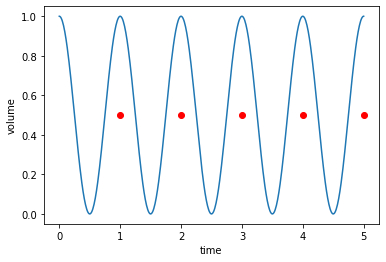

In [8]:
cos_1_vector = (cosine(time_vector, 1))
plt.plot(time_vector, cos_1_vector)
plot_freq_points(1, time, y_offset=0.5)
plt.xlabel('time')
plt.ylabel('volume')
plt.show()

    Based on the wave forms that I showed to my friend, he was able to present a simple algorithm to find the wave frequency inside those audios. So the software should work like this:
        1. Find out how many samples of amplitude (volume) are in a second interval
        2. Count how many arrows up (peeks) and how many arrows down (vales) there are in sequence.
        3. Calculate the frequency by dividing the number of peeks and vales divided by two in one second.
        3. verificar a frequência contando o número de picos acontecem em 1 segundo.
    Nice, something like this



In [9]:
def find_frequency(signal, freq=sampling_frequency):
    going_up = signal[0] > signal[1]
    going_down = signal[0] < signal[1]

    wave_length_s = len(signal) / freq
    print(f'Wave duration: {wave_length_s}s')
    print()
    peeks, vales = 0, 0
    sample_t_1 = signal[0]
    for i, sample_t in enumerate(signal[1:]):
        if (sample_t > signal[i]) and going_down:
            peeks += 1
            going_down = False
            going_up = True

        elif (signal[i] > sample_t) and going_up:
            vales += 1
            going_up = False
            going_down = True
            
        frequency = ((peeks + vales) / 2) / wave_length_s
    print(f'Found {peeks} peeks in {wave_length_s}s.')
    print(f'Found {vales} vales in {wave_length_s}s.')
    print(f'The calculated frequency is {frequency}hz.')
    print()
        
find_frequency(cos_1_vector)
    

Wave duration: 5.0s

Found 5 peeks in 5.0s.
Found 5 vales in 5.0s.
The calculated frequency is 1.0hz.



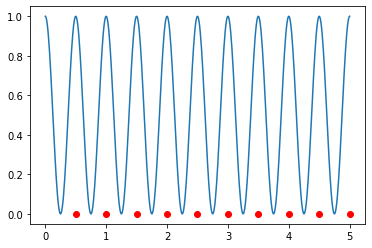

Wave duration: 5.0s

Found 10 peeks in 5.0s.
Found 10 vales in 5.0s.
The calculated frequency is 2.0hz.



In [10]:
cos_2_vector = cosine(time_vector, 2)
plt.plot(time_vector, cos_2_vector)
plot_freq_points(2, time)
plt.show()
find_frequency(cos_2_vector)

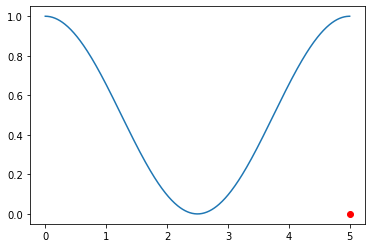

Wave duration: 5.0s

Found 1 peeks in 5.0s.
Found 1 vales in 5.0s.
The calculated frequency is 0.2hz.



In [11]:
cos_02_vector = cosine(time_vector, 0.2)
plt.plot(time_vector, cos_02_vector)
plot_freq_points(0.2, time)
plt.show()
find_frequency(cos_02_vector)

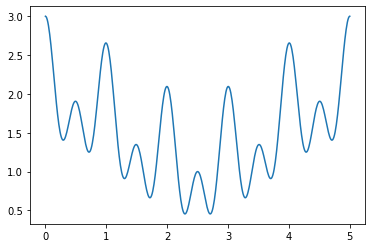

Wave duration: 5.0s

Found 10 peeks in 5.0s.
Found 10 vales in 5.0s.
The calculated frequency is 2.0hz.



In [12]:
combined_cosine_vector = cos_02_vector + cos_2_vector + cos_1_vector
plt.plot(time_vector, combined_cosine_vector)
plt.show()
find_frequency(combined_cosine_vector)

    Heck! it stopped working. We will need to find a way to identify those frequency components...
   

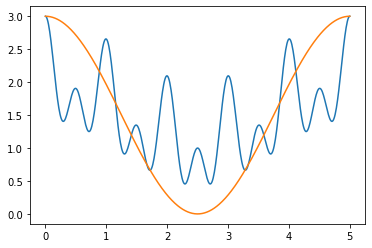

Wave duration: 5.0s

Found 10 peeks in 5.0s.
Found 10 vales in 5.0s.
The calculated frequency is 2.0hz.



In [13]:
plt.plot(time_vector, combined_cosine_vector)
plt.plot(time_vector, 3*cos_02_vector)
# plt.plot(time_vector, 3*cos_2_vector)
# plt.plot(time_vector, 3*cos_1_vector)
plt.show()
find_frequency(combined_cosine_vector)

# And now?

In [14]:
def rotated_freq(time_vector, signal, f):
    k = -2j * np.pi
    return np.exp(k*f*time_vector) * signal

In [15]:
def polar(z):
    a= z.real
    b= z.imag
    r = math.hypot(a,b)
    theta = math.atan2(b,a)
    return theta, r

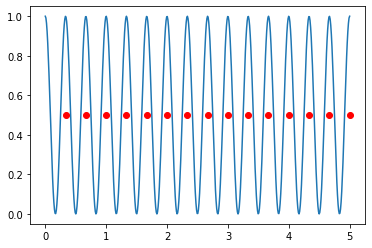

In [17]:
cos_3 = cosine(time_vector, 3)
plt.plot(time_vector, cos_3)
plot_freq_points(3, time, y_offset=0.5)
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

ax = plt.subplot(111, projection='polar')

line, = ax.plot([], [], lw=2)

def init():
    ax.plot([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    rf = rotated_freq(time_vector, cos_3, i * 0.1)
    rf_polar = np.array([polar(el) for el in rf])
    rf_theta = [el[0] for el in rf_polar] 
    rf_r = [el[1] for el in rf_polar]
    ax.clear()
    ax.plot(rf_theta, rf_r)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=30, interval=100, blit=True)

HTML(anim.to_html5_video())

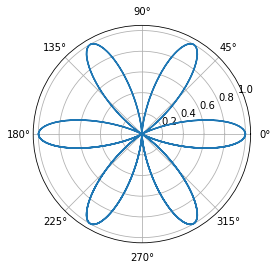

In [18]:
rf = rotated_freq(time_vector, cos_3, 0.5)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

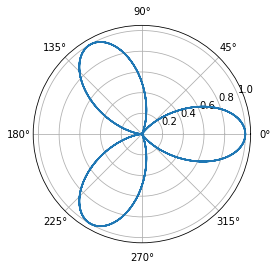

In [19]:
rf = rotated_freq(time_vector, cos_3, 1)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

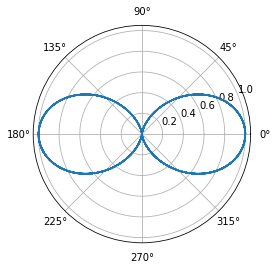

In [20]:
rf = rotated_freq(time_vector, cos_3, 1.5)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

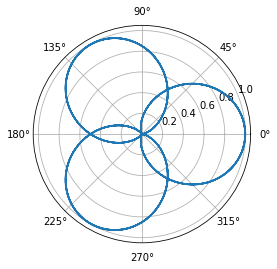

In [21]:
rf = rotated_freq(time_vector, cos_3, 2)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

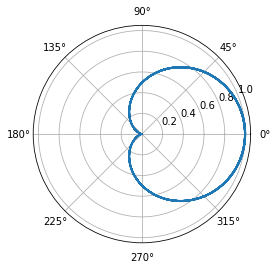

In [22]:
rf = rotated_freq(time_vector, cos_3, 3)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

In [26]:
mean = np.mean(rf)
print(mean.real)
print(mean.imag)

0.25150247236212453
8.704148513061228e-17


In [38]:
mass_centers_real = []
mass_centers_imag = []
for i in np.arange(0, 100, 0.1):
    rf = rotated_freq(time_vector, cos_3, i)
    mean = np.mean(rf)
    mass_centers_real.append(mean.real)
    mass_centers_imag.append(mean.imag)


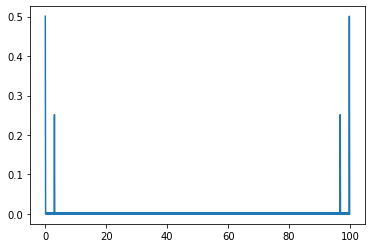

In [39]:
plt.plot(np.arange(0, 100, 0.1), mass_centers_real)

In [49]:
mass_centers_real = []
mass_centers_imag = []
for i in np.arange(0.1, 99, 0.1):
    rf = rotated_freq(time_vector, combined_cosine_vector, i)
    mean = np.sum(rf)
    mass_centers_real.append(mean.real)
    mass_centers_imag.append(mean.imag)


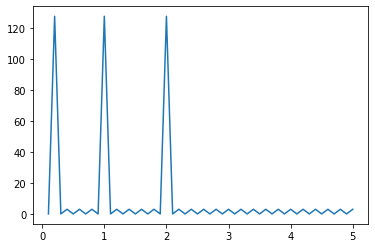

In [51]:
plt.plot(np.arange(0.1, 99, 0.1)[:50], mass_centers_real[:50])